<a href="https://colab.research.google.com/github/leobioinf0/Machine-Learning-Advanced/blob/main/S12_T01_Pipelines_grid_search_text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IT Academy - Data Science with Python
## [Sprint 12. Machine learning avançat](https://github.com/jesussantana/Supervised-Regression/blob/main/notebooks/S12_T01_Supevised_Regression.ipynb) 
### [S12 T01: Pipelines, grid search i text mining](https://github.com/jesussantana/Supervised-Regression) 



#### Exercises: 

We are starting to get acquainted with Pipelines, grid search and text mining. Let’s start with a few basic exercises.

- Level 1
    - Exercise 1: 
        - Use the data set you want and do a pipeline and a gridsearch using the Random Forest algorithm.
    - Exercise 2: 
        - Use a text in English that you want and calculate the frequency of the words
- Level 2
    - Exercise 1: 
        - Remove stopwords and stemming your dataset.

- Level 3
    - Exercise 1: 
        - Perform sentiment analysis on your dataset.

Resources
Classroom resources and https://www.nltk.org

# Setup

## Upgrade modules

In [ ]:
!pip3 install --upgrade matplotlib
!pip3 install --upgrade scikit-learn
!pip3 install --upgrade numpy
!pip3 install --upgrade pandas
!pip3 install --upgrade seaborn

## Importing Dependencies

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import math
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

np.random.seed(130)
sns.set(style='whitegrid', palette='Set2', font_scale=1.2)
sns.set(rc={'figure.figsize':(12,7)})

## Define functions

In [3]:
def mk_dir(name):
    '''
    Create directory with the name passed in the case that it does not exist and return its full path.
    '''
    path = os.path.join(os.getcwd(), name)
    if not os.path.exists(path):
        try:
            os.makedirs(path, 0o700)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
        print("Directory created: {}".format(path))
    else:
        print("Directory already existing: {}".format(path))
    return path



def class_metrics(model, name, X_train, X_test, y_train, y_test, plt_path):
    '''
    Evaluate a classification model and calculate various metrics. Return the metrics in a dictionary
    '''
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    
    scores = {'Model': name,
        'Accuracy':accuracy_score(y_test,y_pred).round(4),
        'B_Accuracy':balanced_accuracy_score(y_test,y_pred).round(4),
        'F1_Score':f1_score(y_test,y_pred).round(4),
        'Precision':precision_score(y_test,y_pred).round(4),
        'Recall':recall_score(y_test,y_pred).round(4),
        'Specificity' : recall_score(y_test, y_pred, pos_label=0).round(4),
        'FP_rate' : (1 - recall_score(y_test, y_pred, pos_label=0)).round(4),
        'Misclass_rate' : zero_one_loss(y_test, y_pred).round(4),
        'Misclass' : zero_one_loss(y_test, y_pred, normalize=False).round(4),
        'TP' : conf_matrix[1, 1].round(4),
        'TN' : conf_matrix[0, 0].round(4),
        'FP' : conf_matrix[0, 1].round(4),
        'FN' : conf_matrix[1, 0].round(4)}
    
    print("Confusion matrix :\n{}".format(conf_matrix))

    conf_matrix = confusion_matrix(y_test,y_pred,normalize='true')
    print("Normalized Confusion matrix:\n{}".format(conf_matrix))
    

    scores_table=pd.DataFrame(data=scores.items(), columns=["METRIC", "VALUES"])
    desc_table=pd.DataFrame(data=model.get_params().items(), columns=["PARAMS", "VALUES"])

    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, square=True, ); 
    desc_t = ax.table(cellText=desc_table.values,
                colLabels=desc_table.columns,
                bbox=[1.5, 0, 1.0, 1.0])
    desc_t.auto_set_column_width(col=list(range(len(desc_table.columns))))

    scores_t = ax.table(cellText=scores_table.values,
                colLabels=scores_table.columns,
                bbox=[-1.1, 0, 1.0, 1.0])
    scores_t.auto_set_column_width(col=list(range(len(scores_table.columns))))
    plt.title(name)
    plt.savefig(plt_path)
    plt.show()

    return scores

def rounder(n):
    """
    Round up to the first digit that is not zero
    """
    if n == 0:
        return n
    else:
        k = 1 - int(math.log10(n))
        return round(n, 1 if n > 1 else k)

def describer(dataframe):
    """
    Description of dataframe
    """
    desc_df = round(dataframe.describe(include="all"),2).T
    desc_df["unique"]=dataframe.nunique()
    desc_df["NullAny"]= dataframe.isnull().any()
    desc_df["NullSum"]=dataframe.isnull().sum()
    desc_df["NullPct"]=(dataframe.isnull().sum()/len(dataframe)*100).apply(rounder)
    desc_df["dtypes"]=dataframe.dtypes
    desc_df["dtypes"] = desc_df["dtypes"].astype('category')
    desc_df.sort_values(by="dtypes", inplace=True)
    return(desc_df)

def impute_age(input_df):
    titles = ['Mrs. ','Ms. ','Miss. ','Mr. ','Master. ','Dr. ']
    for title in titles: 
        title_mean_age = round(input_df[(input_df.name.str.contains(title))]['age'].mean())
        input_df.loc[input_df.name.str.contains(title),'age'] = input_df.loc[input_df.name.str.contains(title),'age'].fillna(value=title_mean_age)
    
    input_df.age = np.ceil(input_df.age)
    return input_df

def impute_fare(input_df):
    for i in input_df.loc[input_df.fare.isnull()].index:
        input_df.loc[i,"fare"] = input_df.loc[(input_df.pclass==input_df.iloc[i].pclass)&
                                              (input_df.embarked==input_df.iloc[i].embarked),"fare"].mode()[0]
    return input_df

def impute_embarked(input_df):
    for i in input_df.loc[input_df.embarked.isnull()].index:
        input_df.loc[i,"embarked"] = input_df.loc[(input_df.pclass==input_df.iloc[i].pclass)&
                                                  (input_df.cabin.str.match(input_df.iloc[i].cabin[:-1])),"embarked"].mode()[0]
    input_df.embarked = input_df.embarked.astype("category").cat.codes
    return input_df

def process_cabin(input_df):
    input_df['cabin'] = pd.Series([i if pd.isnull(i) else i[0] for i in input_df['cabin']])
    return input_df

def process_sex(input_df):
    input_df.sex = input_df.sex.astype("category").cat.codes
    return input_df

def process_pclass(input_df):
    input_df.pclass = input_df.pclass.astype("category").cat.codes
    return input_df

def impute_cabin(input_df):
    i = 0
    while input_df.cabin.isnull().any():
        nulls_indexes = input_df[input_df.cabin.isnull()].index
        for index in nulls_indexes:
            e,p,f = input_df.loc[index,["embarked","pclass", "fare"]].values
            cabin_mode = input_df.loc[(input_df.embarked==e)&(input_df.pclass==p)&((input_df.fare>=f-i)& (input_df.fare<=f+i)),"cabin"].mode().tolist()
            if len(cabin_mode) > 0:
                input_df.loc[index] = input_df.loc[index].fillna(value=cabin_mode[0])
        i=i+1
    input_df.cabin = input_df.cabin.astype("category").cat.codes
    return input_df


## Define classes

In [4]:

class AgeImputer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

class DropColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = list(columns)

    def transform(self, X, **transform_params):
        cpy_df = X.drop(self.columns, axis=1).copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

class FareImputer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

class EmbarkedImputer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self
class CabinProcessor():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

class SexProcessor():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

class PclassProcessor():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

class CabinImputer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

## dir

In [7]:
# Definir el directorio de trabajo

#os.chdir('./')
os.chdir('/content/drive/MyDrive/Data_Science_amb_Python/Sprint12-Machine_learning_avancat/Machine-Learning-Advanced')
print(os.getcwd())

/content/drive/MyDrive/Data_Science_amb_Python/Sprint12-Machine_learning_avancat/Machine-Learning-Advanced


# Exercise 1:
Use the data set you want and do a pipeline and a gridsearch using the Random Forest algorithm.

## Loading the Data

The titanic dataset contains the following information on passengers of the titanic:

- **Survival**: Survival 0 = No, 1 = Yes (Prediction Label)
- **Pclass**: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- **Sex**: Sex
- **Age**: Age in years
- **SibSp**: # of siblings / spouses aboard the Titanic
- **Parch**: # of parents / children aboard the Titanic
- **Ticket**: Ticket number
- **Fare**: Passenger fare
- **Cabin**: Cabin number
- **Embarked**: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [8]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [9]:
X.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [10]:
describer(X)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,NullAny,NullSum,NullPct,dtypes
pclass,1309.0,3,NaN,NaN,2.29,0.84,1.0,2.0,3.0,3.0,3.0,False,0,0.00,float64
age,1046.0,98,NaN,NaN,29.88,14.41,0.17,21.0,28.0,39.0,80.0,True,263,20.10,float64
sibsp,1309.0,7,NaN,NaN,0.5,1.04,0.0,0.0,0.0,1.0,8.0,False,0,0.00,float64
parch,1309.0,8,NaN,NaN,0.39,0.87,0.0,0.0,0.0,0.0,9.0,False,0,0.00,float64
fare,1308.0,281,NaN,NaN,33.3,51.76,0.0,7.9,14.45,31.28,512.33,True,1,0.08,float64
body,121.0,121,NaN,NaN,160.81,97.7,1.0,72.0,155.0,256.0,328.0,True,1188,90.80,float64
name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0.00,object
ticket,1309,929,CA. 2343,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0.00,object
cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1014,77.50,object
boat,486,27,13,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,823,62.90,object


## Imputation pipelline

In [12]:
imputer = Pipeline([('drop_columns', DropColumnsTransformer(["sibsp","parch","boat","body","home.dest","ticket"])),
                     ("impute_age", AgeImputer(impute_age)),
                     ('drop_name', DropColumnsTransformer(["name"])),
                     ("impute_fare", FareImputer(impute_fare)),
                     ("impute_embarked", EmbarkedImputer(impute_embarked)),
                    ("process_sex", SexProcessor(process_sex)),
                    ("process_pclass", PclassProcessor(process_pclass)),
                     ("process_cabin", CabinProcessor(process_cabin)),
                     ("impute_cabin", CabinImputer(impute_cabin))])

In [13]:
X = imputer.fit_transform(X)

In [14]:
X.head()

,pclass,sex,age,fare,cabin,embarked
0,0,0,29.0,211.3375,1,2
1,0,1,1.0,151.5500,2,2
2,0,0,2.0,151.5500,2,2
3,0,1,30.0,151.5500,2,2
4,0,0,25.0,151.5500,2,2


In [15]:
describer(X)

,count,mean,std,min,25%,50%,75%,max,unique,NullAny,NullSum,NullPct,dtypes
pclass,1309.0,1.29,0.84,0.0,1.0,2.00,2.00,2.00,3,False,0,0.0,int8
sex,1309.0,0.64,0.48,0.0,0.0,1.00,1.00,1.00,2,False,0,0.0,int8
cabin,1309.0,4.07,1.50,0.0,4.0,4.00,5.00,7.00,8,False,0,0.0,int8
embarked,1309.0,1.49,0.81,0.0,1.0,2.00,2.00,2.00,3,False,0,0.0,int8
age,1309.0,29.88,13.18,1.0,22.0,30.00,36.00,80.00,72,False,0,0.0,float64
fare,1309.0,33.28,51.74,0.0,7.9,14.45,31.28,512.33,281,False,0,0.0,float64


## Transforming pipelline

In [16]:
cat_transformer = Pipeline([('onehot', OneHotEncoder())])
num_transformer = Pipeline([('robustscaler', RobustScaler())])

transformer = ColumnTransformer([('num', num_transformer, ['age', 'fare']),
                                 ('cat', cat_transformer, ['pclass','sex','embarked',"cabin"])])

In [17]:
X = transformer.fit_transform(X)

In [30]:
X = pd.DataFrame(X, columns=transformer.get_feature_names_out()).rename(columns=lambda x: re.sub('cat__|num__','',x))

In [31]:
X.head(2)

,age,fare,pclass_0,pclass_1,pclass_2,sex_0,sex_1,embarked_0,embarked_1,embarked_2,cabin_0,cabin_1,cabin_2,cabin_3,cabin_4,cabin_5,cabin_6,cabin_7
0,-0.071429,8.421302,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.071429,5.864007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
describer(X)

,count,mean,std,min,25%,50%,75%,max,unique,NullAny,NullSum,NullPct,dtypes
age,1309.0,-0.01,0.94,-2.07,-0.57,0.0,0.43,3.57,72,False,0,0.0,float64
cabin_5,1309.0,0.35,0.48,0.00,0.00,0.0,1.00,1.00,2,False,0,0.0,float64
cabin_4,1309.0,0.28,0.45,0.00,0.00,0.0,1.00,1.00,2,False,0,0.0,float64
cabin_3,1309.0,0.06,0.24,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
cabin_2,1309.0,0.10,0.29,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
cabin_1,1309.0,0.06,0.24,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
cabin_0,1309.0,0.02,0.15,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
embarked_2,1309.0,0.70,0.46,0.00,0.00,1.0,1.00,1.00,2,False,0,0.0,float64
embarked_1,1309.0,0.09,0.29,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
embarked_0,1309.0,0.21,0.40,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64


####clf

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=130)

In [34]:
clf = RandomForestClassifier(random_state=130)

In [44]:
round(cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy").mean(),4)

0.7971

In [112]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=130)

In [40]:
pickle.dump(clf, open("clf.pkl", 'wb'))

In [41]:
clf = pickle.load(open("clf.pkl", 'rb'))

In [52]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       162
           1       0.74      0.57      0.64       100

    accuracy                           0.76       262
   macro avg       0.75      0.72      0.73       262
weighted avg       0.76      0.76      0.75       262



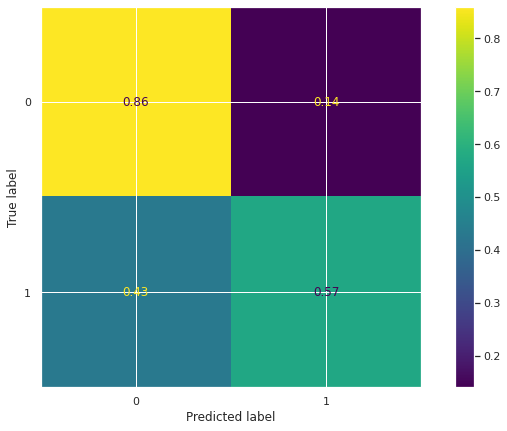

In [43]:
cm = confusion_matrix(y_test,y_pred,normalize='true', labels=clf.classes_).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

####clf randomsearchCV

In [45]:
random_forest_params = {'n_estimators': list(range(50, 1000)),
                      'criterion': ["gini", "entropy"],
                      'max_depth': list(range(2, 15)),
                      "min_samples_split": list(range(2, 5)),
                      "max_features": ["auto", "sqrt", "log2", None],
                      'bootstrap': [True, False]}

param_dist = { **random_forest_params}

In [46]:
random_search = RandomizedSearchCV(clf,param_distributions=param_dist,n_iter=100, cv=5, random_state=130,  scoring="accuracy", verbose=1)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=130),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                        

In [ ]:
pickle.dump(random_search, open("random_search.pkl", 'wb'))

In [128]:
random_search = pickle.load(open("random_search.pkl", 'rb'))

In [48]:
random_search.best_score_

0.8300250626566417

In [129]:
random_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 815}

In [ ]:
y_pred_RS = random_search.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_RS))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       203
           1       0.81      0.56      0.66       125

    accuracy                           0.78       328
   macro avg       0.79      0.74      0.75       328
weighted avg       0.79      0.78      0.77       328



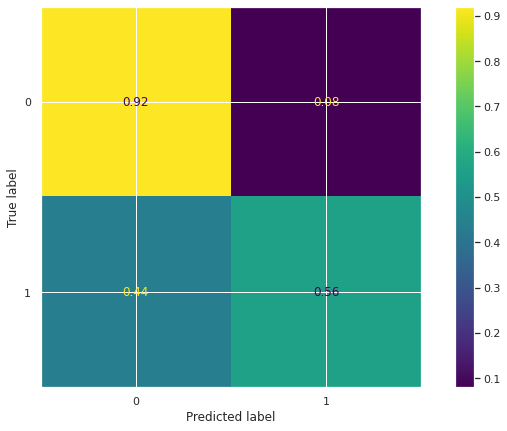

In [56]:
cm = confusion_matrix(y_test,y_pred_RS,normalize='true', labels=random_search.classes_).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot()
plt.show()

In [172]:
random_search_results = pd.DataFrame(random_search.cv_results_)
random_search_results = random_search_results.sort_values(by="rank_test_score")
random_search_results = random_search_results.filter(regex="mean_test_|param_")
random_search_results = random_search_results.rename(columns=lambda x: re.sub('mean_fit_|mean_test_|param_','',x))
random_search_results.rename({'score':'accuracy'}, axis=1, inplace=True)
random_search_results.fillna("None", inplace=True)
random_search_results.bootstrap = np.array(['No', 'Yes'])[random_search_results.bootstrap.astype(int)]
random_search_results.head(2)

,n_estimators,min_samples_split,max_features,max_depth,criterion,bootstrap,accuracy
49,815,2,sqrt,7,gini,Yes,0.830025
56,157,3,auto,8,entropy,Yes,0.829064


####clf GridsearchCV

In [70]:
clf = RandomForestClassifier(random_state=130, criterion="gini", bootstrap=True)

In [71]:
param_grid = {'n_estimators': list(range(800, 850)),
              'max_depth': [6,7,8],
              "min_samples_split": [2,6],
              "max_features": ["auto", "sqrt"]}

In [72]:
grid_search = GridSearchCV(clf,param_grid=random_forest_params, cv=2, scoring="accuracy", verbose=1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 600 candidates, totalling 1200 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=130),
             param_grid={'max_depth': [6, 7, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 6],
                         'n_estimators': [800, 801, 802, 803, 804, 805, 806,
                                          807, 808, 809, 810, 811, 812, 813,
                                          814, 815, 816, 817, 818, 819, 820,
                                          821, 822, 823, 824, 825, 826, 827,
                                          828, 829, ...]},
             scoring='accuracy', verbose=1)

In [ ]:
pickle.dump(grid_search, open("grid_search.pkl", 'wb'))

In [73]:
grid_search = pickle.load(open("grid_search.pkl", 'rb'))

In [74]:
grid_search.best_score_

0.8252138280326362

In [75]:
grid_search.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_split': 6,
 'n_estimators': 800}

In [ ]:
y_pred_GS = grid_search.predict(X_test)

In [77]:
print(classification_report(y_test, y_pred_GS))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       203
           1       0.80      0.56      0.66       125

    accuracy                           0.78       328
   macro avg       0.78      0.74      0.75       328
weighted avg       0.78      0.78      0.77       328



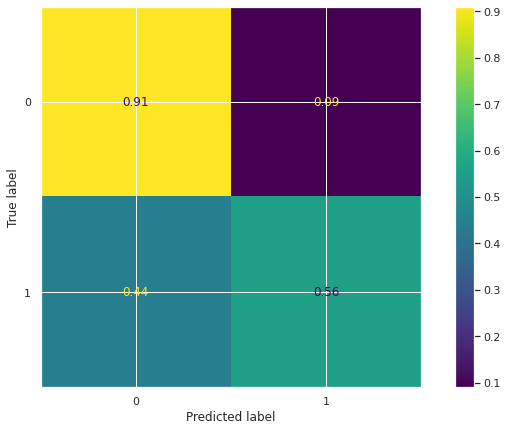

In [78]:
cm = confusion_matrix(y_test,y_pred_GS,normalize='true', labels=grid_search.classes_).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.show()

In [171]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results = grid_search_results.sort_values(by="rank_test_score")
grid_search_results = grid_search_results.filter(regex="mean_test_|param_")
grid_search_results = grid_search_results.rename(columns=lambda x: re.sub('mean_fit_|mean_test_|param_','',x))
grid_search_results.rename({'score':'accuracy'}, axis=1, inplace=True)
grid_search_results.fillna("None", inplace=True)
grid_search_results.head(2)

,max_depth,max_features,min_samples_split,n_estimators,accuracy
299,7,auto,6,849,0.825214
277,7,auto,6,827,0.825214


# Exercise 2:
Use a text in English that you want and calculate the frequency of the words